In [1]:
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.stats import norm
import pymc as pm
print(f"PyMC version - v{pm.__version__}")

PyMC version - v5.22.0


In [2]:
data = pd.read_csv('./data/housing_price.csv')
data.columns

Index(['Unnamed: 0', 'Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Condition1', 'Condition2', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'RoofStyle', 'RoofMatl', 'Exterior2nd',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'FireplaceQu', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold',
       'SaleType', 'SaleConditi

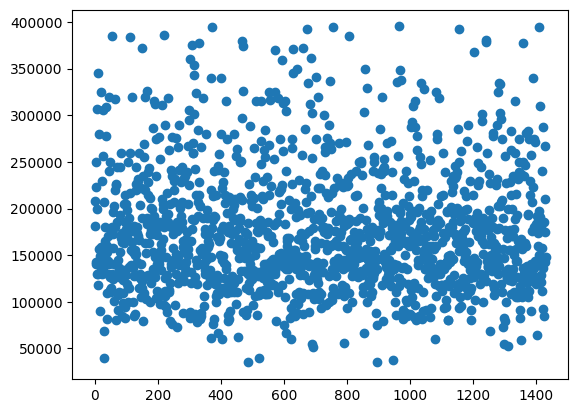

In [3]:
plt.figure()
plt.scatter(range(len(data)),data['SalePrice']);

In [4]:
# to_drop = ['Fence', 'PoolQC','GarageYrBlt', '2ndFlrSF', 'Exterior1st', 'BedroomAbvGr', 'BldgType', 'YearRemodAdd', 'GarageType', 'BsmtFinSF1', 'Neighborhood', 'Fireplaces', 'MasVnrType', 'TotalBsmtSF']
# refer house price data preprocessing notebook for details

df_house = data.copy()
x= df_house.applymap(type).eq(str).any().any()
# nan_cols = x[x>0].index
print(x)

False


/var/folders/5z/y5jrt5n57_q_qvg8yndn3tj00000gn/T/ipykernel_39630/1657672195.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  x= df_house.applymap(type).eq(str).any().any()


In [5]:
(df_house['Utilities'])[468]

2

In [6]:
az.style.use('arviz-darkgrid')
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

def standardize(series,mean,std):
    return (series - mean)/std

0


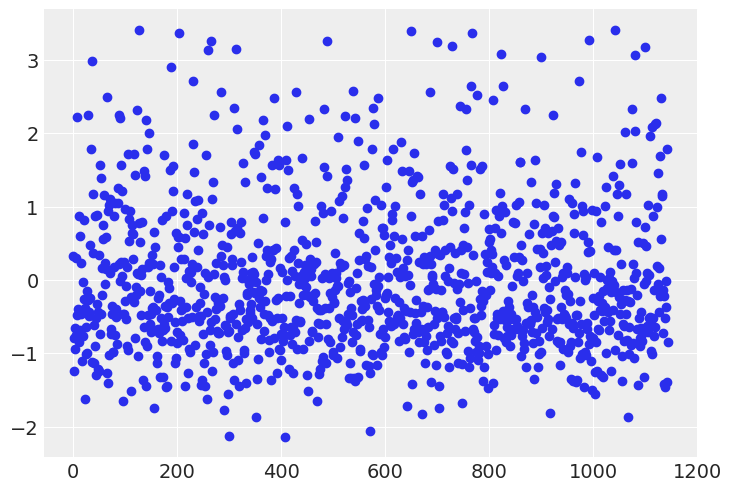

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df_house.drop(columns=['Id','Unnamed: 0','SalePrice']),
    df_house['SalePrice'],
    test_size=0.2,
    random_state=23
    )
mean_train = (X_train.mean(axis=0))
std_train = X_train.std(axis=0)
print(np.sum(std_train==0))

mean_ytrain = y_train.mean(axis=0)
std_ytrain = y_train.std(axis=0)

X_train = (X_train - mean_train)/std_train
X_test = (X_test - mean_train)/std_train
y_train = (y_train - mean_ytrain)/std_ytrain
y_test = (y_test - mean_ytrain)/std_ytrain

plt.figure()
plt.scatter(range(len(X_train)),y_train)

## Bayesian model

In [8]:
cols = (df_house.columns).drop(['Id','Unnamed: 0','SalePrice'])

In [9]:
import numpy.ma as ma

print(X_train[X_train.isna().any(axis=1)])
print(ma.isMaskedArray(X_train))

Empty DataFrame
Columns: [MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Condition1, Condition2, HouseStyle, OverallQual, OverallCond, YearBuilt, RoofStyle, RoofMatl, Exterior2nd, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, FireplaceQu, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition]
Index: []

[0 rows x 65 columns]
False


In [10]:
coords = {"feature":cols}

with pm.Model(coords=coords) as lr_model:
    X = pm.Data("X",X_train,dims=["obs","feature"])
    y = pm.Data("y",y_train,dims=["obs"])
    
    intercept = pm.Normal("intercept",mu=0,sigma=10)
    betas = pm.Normal("betas",mu=0,sigma=2,dims="feature")
    sigma = pm.HalfNormal("sigma",sigma=1)

    mu = pm.Deterministic("mu",intercept + pm.math.dot(X,betas))

    y_obs = pm.Normal("SalePrice",mu=mu,sigma=sigma,observed=y)
    idata = pm.sample();
    idata.extend(pm.sample_posterior_predictive(idata, return_inferencedata=True))
    pm.compute_log_likelihood(idata)
    

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, betas, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
Sampling: [SalePrice]


Output()

Output()

In [11]:
az.summary(idata);

In [12]:
loo = az.loo(idata,pointwise=True)

/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


4


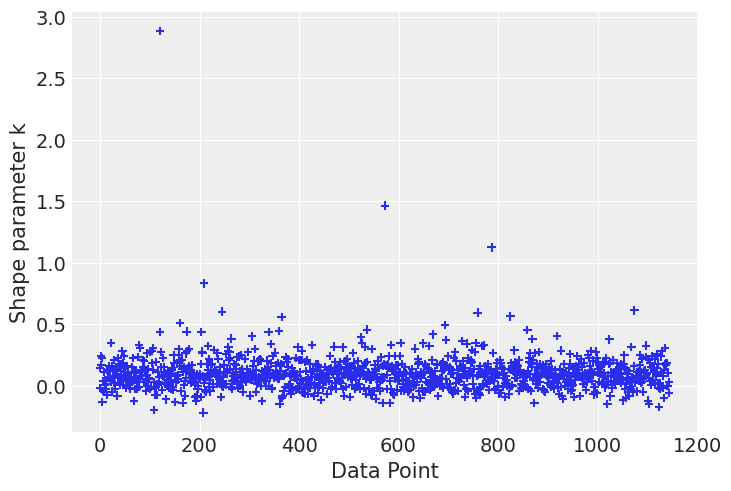

In [13]:
az.plot_khat(loo)
k_values = loo.pareto_k.values
high_kval = k_values[k_values>0.7]
print(len(high_kval))

<AxesSubplot: xlabel='SalePrice'>

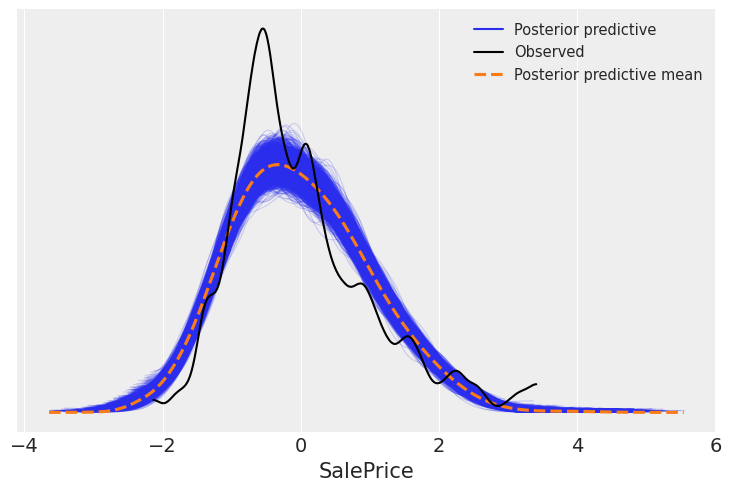

In [14]:
az.plot_ppc(idata, group="posterior", data_pairs={"SalePrice": "SalePrice"})

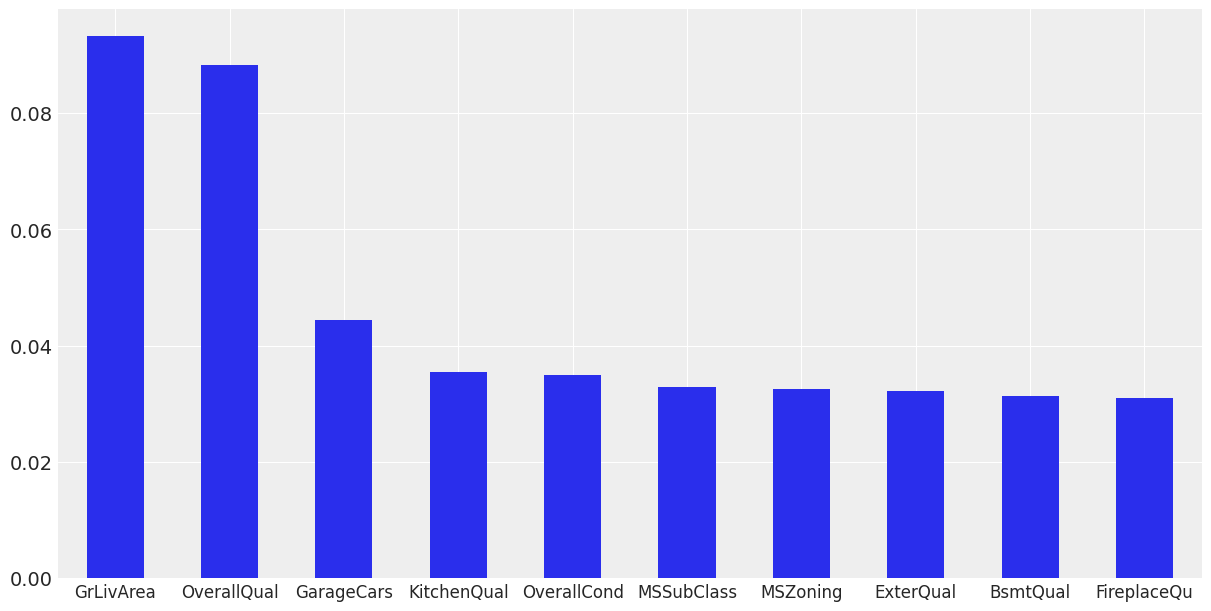

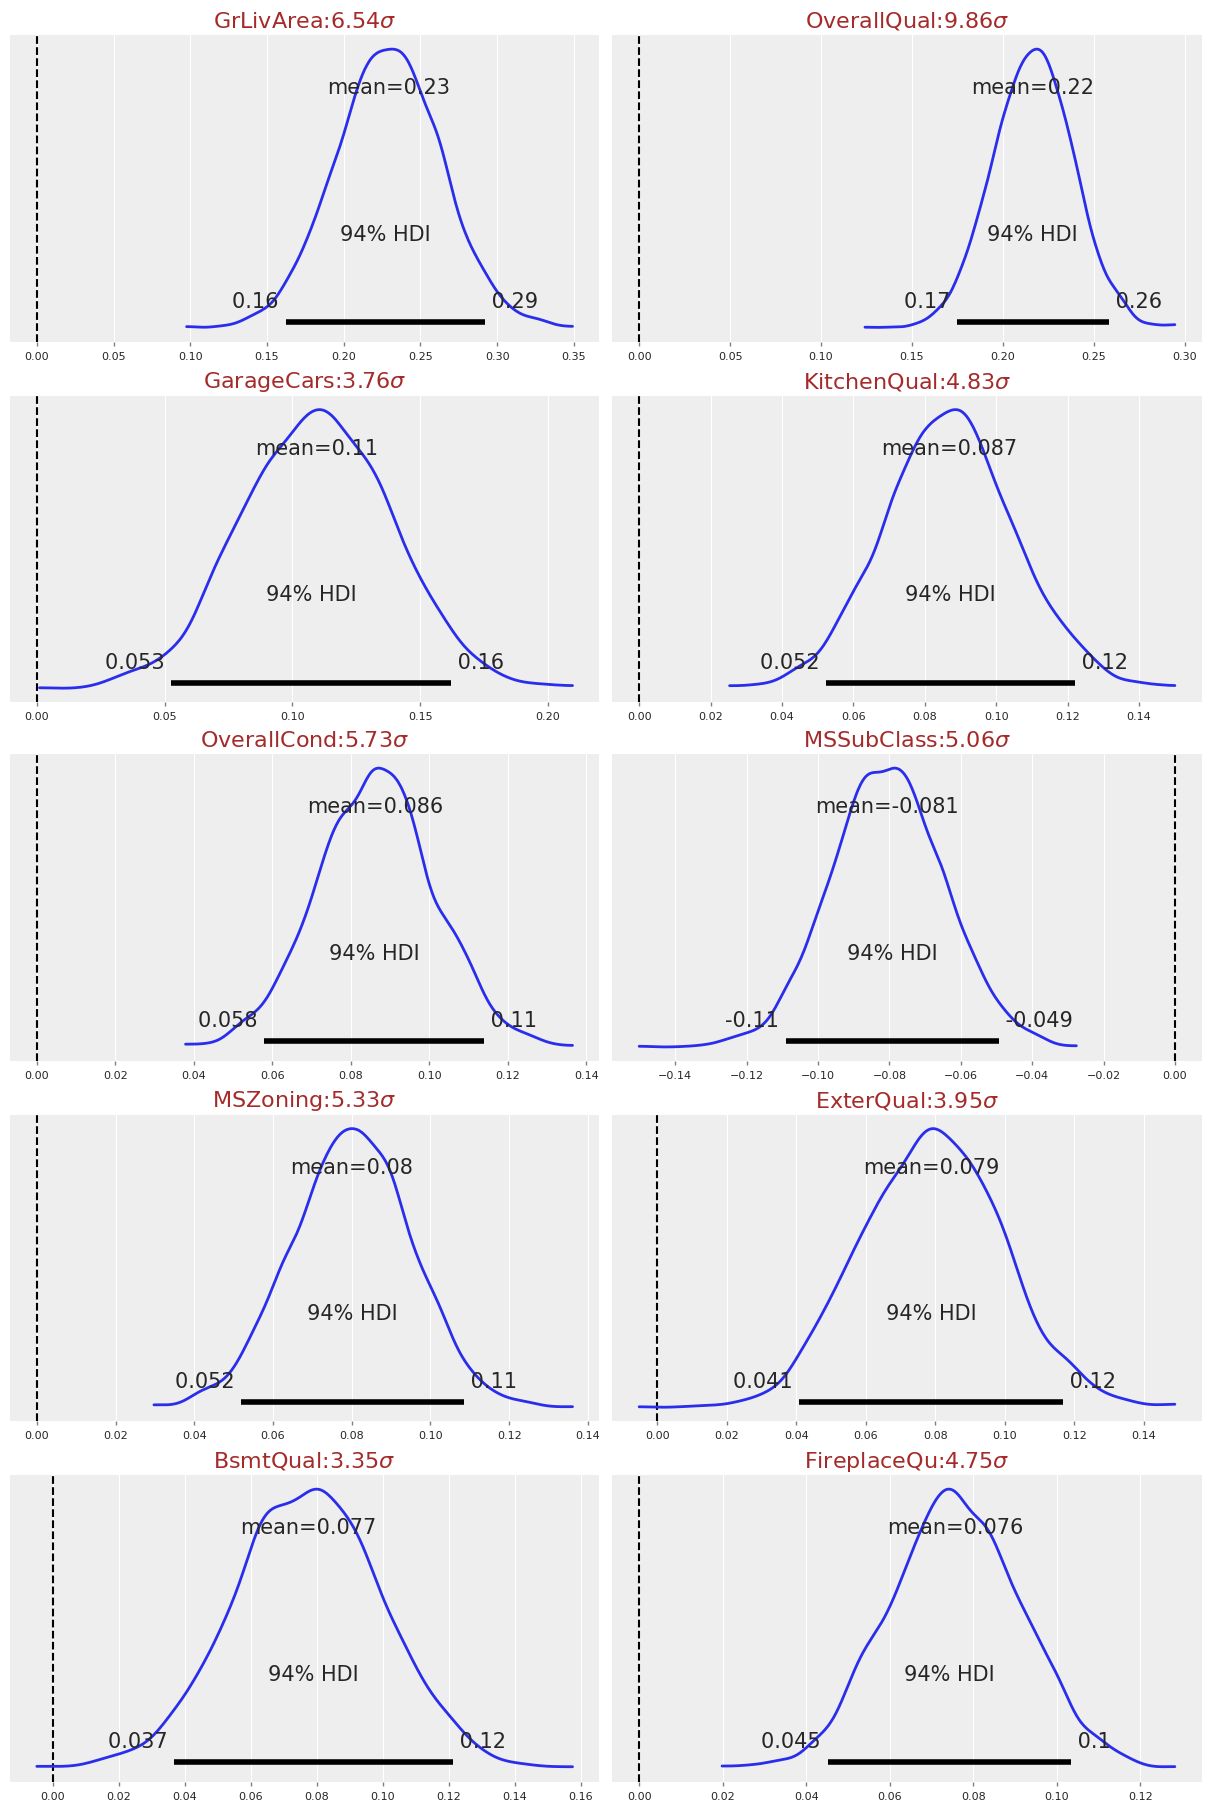

In [15]:
df_bayes_model = az.summary(idata,var_names="betas",kind='all')[["mean","sd","hdi_3%","hdi_97%"]]
df_bayes_model.index = cols
df_bayes_model["mean_abs"] = abs(df_bayes_model["mean"])
df_bayes_model["confidence"] = df_bayes_model["mean_abs"]/df_bayes_model["sd"]
df_bayes_model.sort_values(by='mean_abs',ascending=False,inplace=True)
main_features = df_bayes_model.index[:10]
(df_bayes_model[:10]["mean_abs"]/df_bayes_model['mean_abs'].sum()).plot(kind='bar',figsize=(12,6),legend=False)
plt.xticks(rotation=0,fontsize=12)
# plt.xlabel(fontsize=12)
plt.tight_layout()
plt.savefig('./bm_feat.pdf')
plt.show()
fig,ax = plt.subplots(5,2,figsize=(12,18))

for i in range(len(main_features)):
    row, col = divmod(i,2)
    ax[row,col].axvline(0,ls='--',c='k')
    az.plot_posterior(idata,var_names=['betas'],coords={"feature":main_features[i]},lw=2,ax=ax[row,col])
    ax[row,col].set_title(
        f"{main_features[i]}:{round(df_bayes_model.loc[main_features[i],'confidence'],2)}$\sigma$",
        c='brown'
        )
    ax[row,col].tick_params(axis='x',labelsize=8)
# plt.axvline(0,ls='--',c='k')
plt.savefig('./param_post_bm.pdf')
plt.show()



In [16]:

# Compute HDI

hdi_betas = az.hdi(idata,hdi_prob=0.01)["betas"]
# print(hdi_betas)
zero_consistent = (hdi_betas.sel(hdi='lower')<0 & (hdi_betas.sel(hdi='higher')>0))
predictor_zero_consistent = hdi_betas["feature"].values[zero_consistent]
print(predictor_zero_consistent,len(predictor_zero_consistent))
pd.set_option('display.max_rows', None)  
# display(az.summary(idata,var_names=['betas']))

['MSSubClass' 'LotFrontage' 'Alley' 'LotShape' 'Condition2' 'HouseStyle'
 'BsmtCond' 'BsmtFinType1' 'BsmtUnfSF' 'Electrical' 'LowQualFinSF'
 'KitchenAbvGr' 'GarageQual' 'GarageCond' 'PoolArea' 'MiscFeature'
 'YrSold'] 17


In [17]:
# az.plot_pair(idata,var_names = ["betas"],coords={"feature":predictor_zero_consistent},kind='kde',marginals=True);

In [18]:
# posterior = idata.posterior.reset_coords(["obs"], drop=True)
with lr_model:
    pm.set_data({"X":X_test})
    idata_test = pm.sample_posterior_predictive(
        idata,
        var_names = ['mu'],
        return_inferencedata=True,
    )

Sampling: []


Output()

In [19]:
mu_test = idata_test.posterior_predictive["mu"].mean(dim=("chain","draw"))

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test,mu_test)
r2 = r2_score(y_test,mu_test)

print("MSE: ",mse)
print("R2 score: ",r2)

MSE:  0.17555460342983806
R2 score:  0.8475271120414409


0.00833977889437013 0.41964107951206026


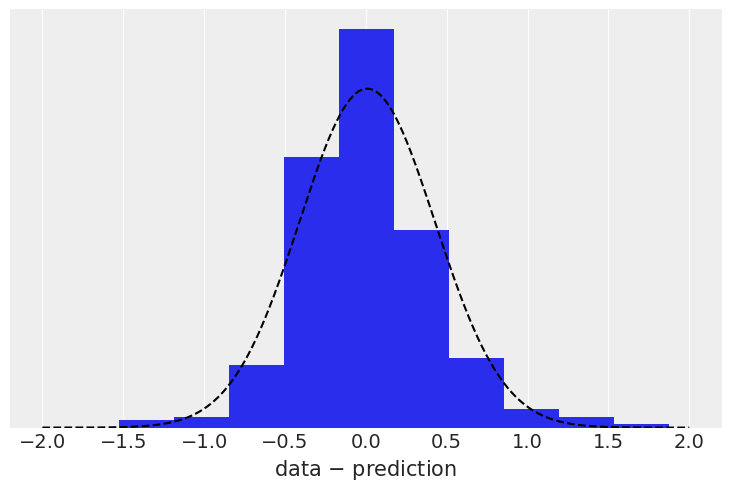

In [20]:
residuals = y_test - mu_test
mean_res = residuals.mean()
std_res = residuals.std()
print(mean_res,std_res)
x= np.linspace(-2,2,1000)
plt.plot(x,norm.pdf(x,mean_res,std_res),ls='--',c='k')
plt.yticks([])
plt.xlabel(r"data $\minus$ prediction")
plt.hist(residuals,density=True)
plt.tight_layout()
plt.savefig('./res_bm.pdf')

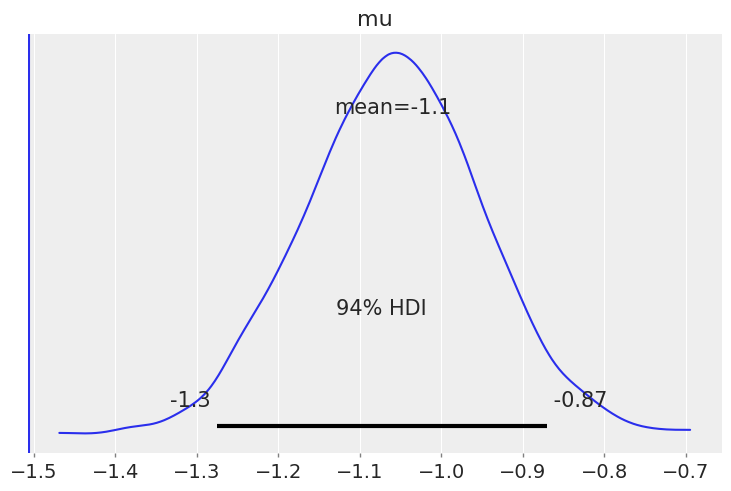

In [21]:
posterior_mu = idata_test.posterior_predictive["mu"]
# print(posterior_mu[0])
k=46
az.plot_posterior(posterior_mu.sel(mu_dim_0=k))
plt.axvline((y_test.to_list()[k]))

### T distribution 

In [22]:
with pm.Model(coords=coords) as bm_model_studentT:
    X  = pm.Data("X",X_train,dims=['obs','features'])
    y = pm.Data("Y",y_train ,dims=["obs"])

    intercept = pm.Normal("intercept",mu=0,sigma=2)
    betas = pm.StudentT('betas',mu=0,sigma=1,nu=20,dims=["feature"])
    sigma = pm.HalfNormal("sigma",sigma=1)

    mu = pm.Deterministic("mu",intercept + pm.math.dot(X,betas))
    y_obs = pm.Normal("SalePrice",mu=mu,sigma=sigma,observed=y)

    idata_Tdist= pm.sample(draes=2000,tune=1000)
    pm.compute_log_likelihood(idata_Tdist);

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, betas, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.


Output()

Sampling: [SalePrice]


Output()

(-5.0, 5.0)

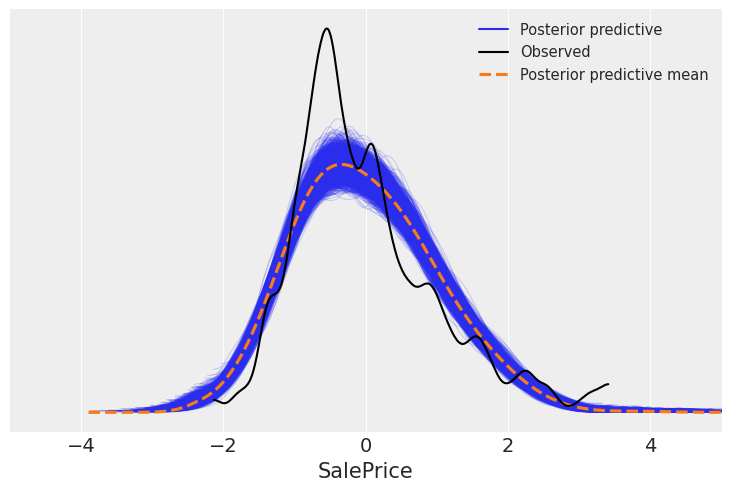

In [23]:
with bm_model_studentT:
    posterior_predictive =pm.sample_posterior_predictive(idata_Tdist,return_inferencedata=True)
    idata_Tdist.extend(posterior_predictive)
az.plot_ppc(idata_Tdist,group="posterior",data_pairs={"SalePrice":"SalePrice"})
plt.xlim(-5,5)

In [24]:
with bm_model_studentT:
    pm.set_data({"X":X_test})
    idata_Tdist_test = pm.sample_posterior_predictive(idata_Tdist,var_names=["mu"],return_inferencedata=True)

y_pred_tdist = idata_Tdist_test.posterior_predictive["mu"].mean(("chain","draw"))

print("MSE : ",mean_squared_error(y_pred_tdist,y_test))
print("R2 score : ",r2_score(y_pred_tdist,y_test))

Sampling: []


Output()

MSE :  0.175065539929164
R2 score :  0.8176970187933092


In [25]:
with pm.Model(coords=coords) as model_hierarchical:
    X = pm.Data("X", X_train, dims=["obs", "feature"])
    y = pm.Data("y", y_train, dims=["obs"])

    # Hyperpriors
    mu_beta = pm.Normal("mu_beta", mu=0, sigma=2)
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=1)

    # Hierarchical prior for betas
    betas = pm.Normal("betas", mu=mu_beta, sigma=sigma_beta, dims="feature")

    intercept = pm.Normal("intercept", mu=0, sigma=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = pm.Deterministic("mu", intercept + pm.math.dot(X, betas))
    y_obs = pm.StudentT("SalePrice", mu=mu, sigma=sigma,nu=20, observed=y)

    idata_hier = pm.sample(draws=2000, tune=1000)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_beta, sigma_beta, betas, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 70 seconds.


In [26]:
with model_hierarchical:
    pm.set_data({"X":X_test})
    idata_hier_test = pm.sample_posterior_predictive(idata_hier,var_names=["mu"],return_inferencedata=True)

y_pred = idata_hier_test.posterior_predictive["mu"].mean(["draw","chain"])
print("MSE : ",mean_squared_error(y_pred,y_test))
print("R2 score : ",r2_score(y_pred,y_test))

Sampling: []


Output()

MSE :  0.14095800154932822
R2 score :  0.8627454580577698


### Lasso Regression

In [27]:
with pm.Model(coords=coords) as lasso_model:
    X= pm.Data("X",X_train,dims=["obs","features"])
    Y = pm.Data("Y",y_train, dims=["obs"])

    intercept = pm.Normal("intercept",mu=0,sigma=1)
    sigma = pm.HalfNormal("sigma",sigma=1)
    lambda_ = pm.HalfNormal("lambda",sigma=2)
    betas = pm.Laplace("betas",mu=0, b=lambda_,dims=["feature"])
    
    mu = pm.Deterministic("mu",intercept+pm.math.dot(X,betas))
    y_obs = pm.StudentT("SalePrice",mu=mu,sigma=sigma,nu=10,observed =Y)

    idata_lasso = pm.sample(draws=2000,tune=1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, sigma, lambda, betas]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 75 seconds.


In [28]:
with lasso_model:
    pm.set_data({"X":X_test})
    idata_lasso_test = pm.sample_posterior_predictive(idata_lasso,var_names=["mu"],return_inferencedata=True)

y_pred_lasso = idata_lasso_test.posterior_predictive["mu"].mean(["chain","draw"])
print("MSE :",mean_squared_error(y_pred_lasso,y_test))
print("R2 score :",r2_score(y_pred_lasso,y_test))

Sampling: []


Output()

MSE : 0.13789108276155834
R2 score : 0.8643756060201829


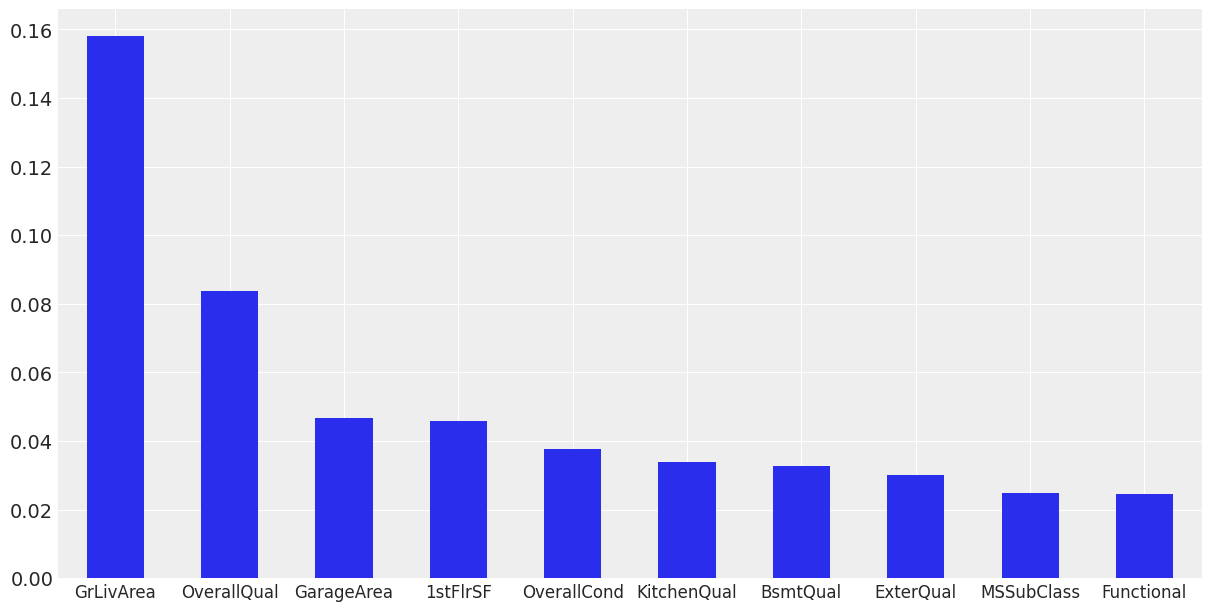

In [29]:
df_bayes_model_lasso = az.summary(idata_lasso,var_names=['betas'],kind='all')
df_bayes_model_lasso.index =cols
df_bayes_model_lasso["abs_mean"] = abs(df_bayes_model_lasso['mean'])
df_bayes_model_lasso["abs_mean"] = df_bayes_model_lasso["abs_mean"]/df_bayes_model_lasso["abs_mean"].sum()
df_bayes_model_lasso['confidence'] = df_bayes_model_lasso["abs_mean"]/df_bayes_model_lasso["sd"]
df_bayes_model_lasso.sort_values(by='abs_mean',ascending=False,inplace=True)
main_features_lasso = df_bayes_model_lasso[:10].index
(df_bayes_model_lasso["abs_mean"])[:10].plot(kind='bar',legend=False,figsize=(12,6),)
plt.xticks(rotation=0,fontsize=12)
plt.tight_layout()
plt.savefig('./bm_lasso_feat.pdf')
plt.show()


In [30]:
df_bayes_model_lasso.sort_values(by=["confidence"],ascending=False)[:10]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,abs_mean,confidence
GrLivArea,0.356,0.025,0.309,0.403,0.0,0.0,4744.0,4837.0,1.0,0.157941,6.317657
OverallQual,0.189,0.018,0.155,0.221,0.0,0.0,8072.0,5886.0,1.0,0.083851,4.658385
OverallCond,0.085,0.011,0.064,0.107,0.0,0.0,6846.0,5800.0,1.0,0.037711,3.428249
Functional,0.055,0.010,0.035,0.074,0.0,0.0,7883.0,5960.0,1.0,0.024401,2.440106
KitchenQual,0.076,0.014,0.050,0.103,0.0,0.0,8249.0,6255.0,1.0,0.033718,2.408417
1stFlrSF,0.103,0.019,0.068,0.138,0.0,0.0,4965.0,6071.0,1.0,0.045697,2.405081
MSZoning,0.054,0.011,0.033,0.077,0.0,0.0,6971.0,6078.0,1.0,0.023957,2.177946
GarageArea,0.105,0.022,0.065,0.145,0.0,0.0,4776.0,5154.0,1.0,0.046584,2.117448
MSSubClass,-0.056,0.012,-0.078,-0.033,0.0,0.0,6449.0,6099.0,1.0,0.024845,2.070393
MasVnrArea,0.050,0.011,0.029,0.071,0.0,0.0,8355.0,6201.0,1.0,0.022183,2.016617


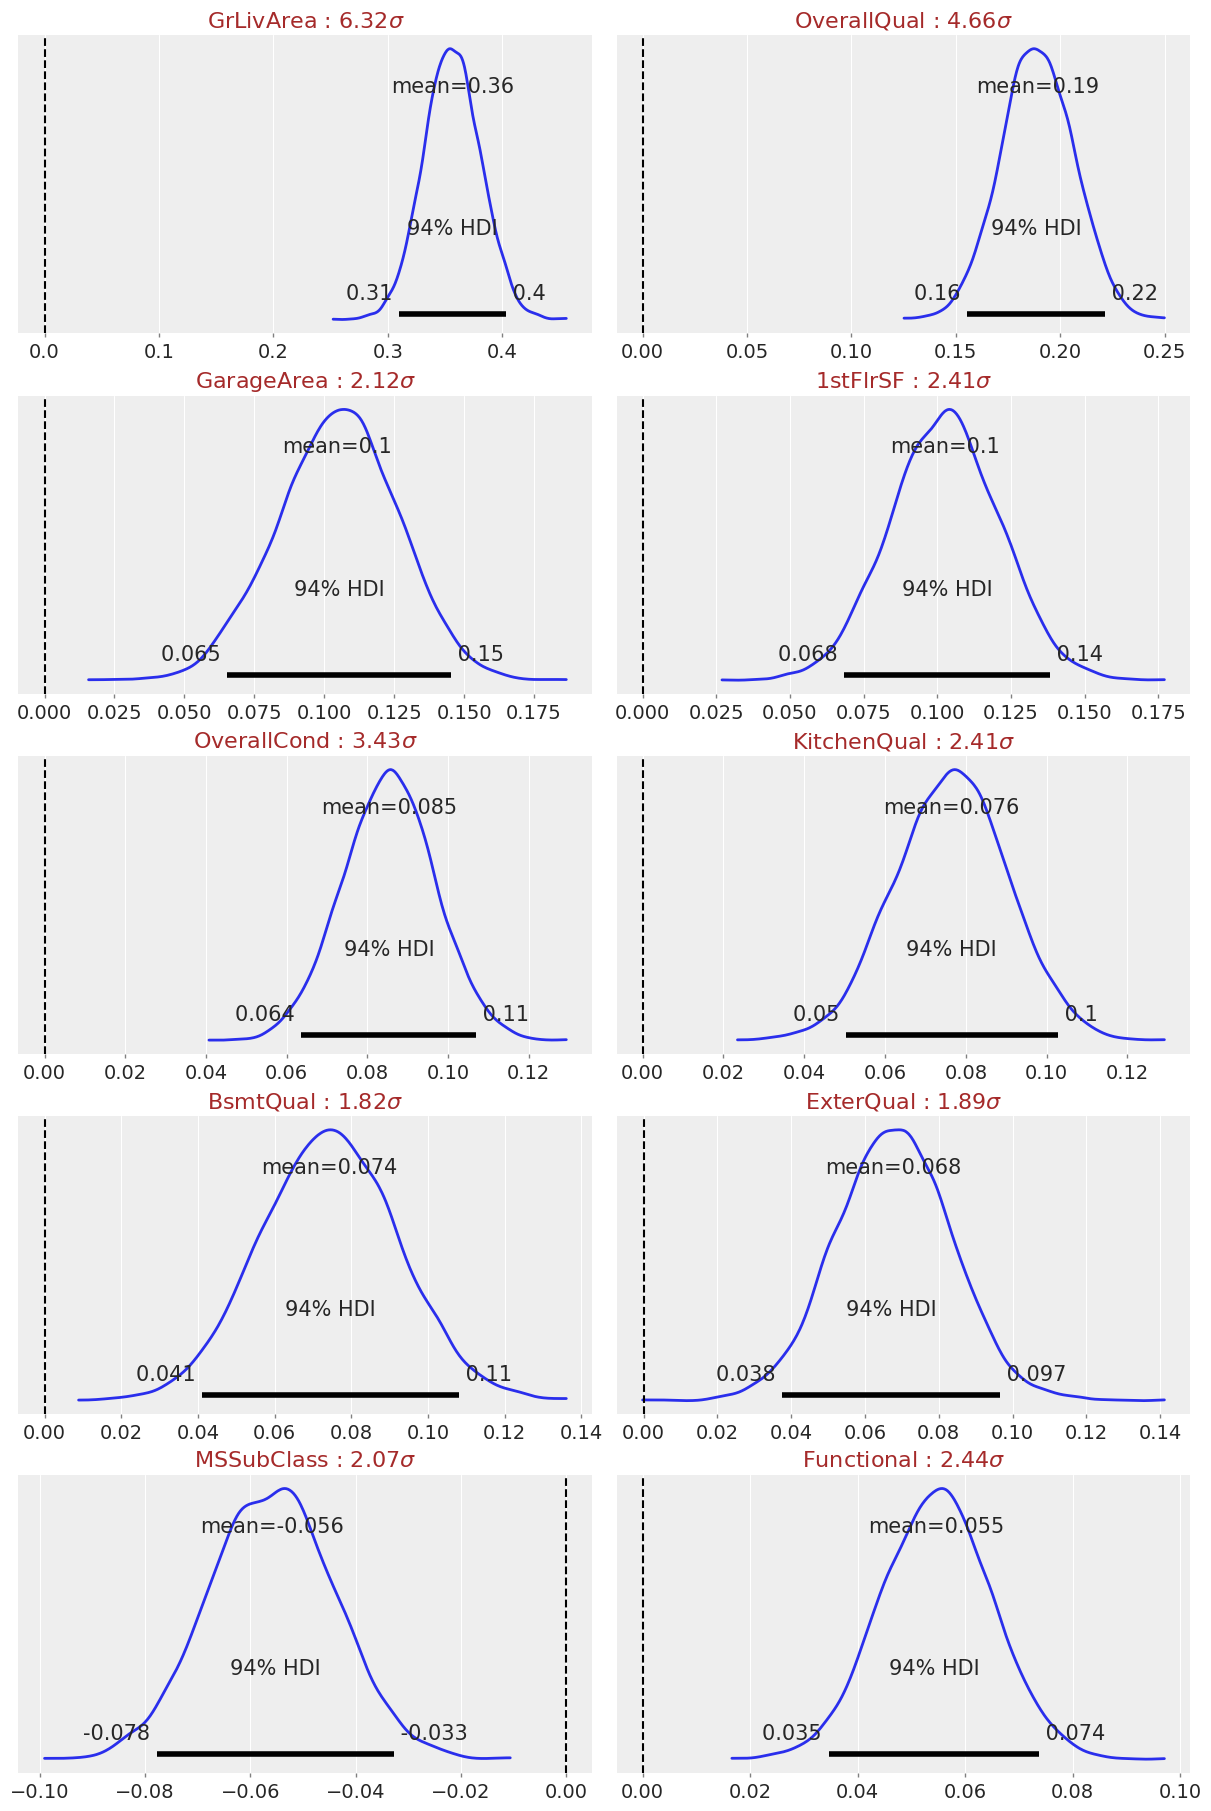

In [31]:
fig,ax = plt.subplots(5,2,figsize=(12,18))

for i in range(10):
    row,col = divmod(i,2)
    az.plot_posterior(idata_lasso,var_names=["betas"],coords={"feature":main_features_lasso[i]},lw=2,ax=ax[row,col])
    ax[row,col].set_title(f"{main_features_lasso[i]} : {round(df_bayes_model_lasso.loc[main_features_lasso[i],'confidence'],2)}$\sigma$",c="brown")
    ax[row,col].axvline(0,c='k',ls='--')
plt.savefig('./post_param_bm_lasso.pdf')
plt.show();

### Hierarchical Model

In [32]:
X_train["MSZoning"].value_counts()

MSZoning
 0.376341    898
-2.107295    176
 1.618160     47
-0.865477     15
-3.349114      9
Name: count, dtype: int64

In [33]:
# X_hier = X_train.drop('MSZoning',axis=1)
# col_hier = X_hier.columns
# Zone = X_train["MSZoning"].astype("category").cat.codes
# n_zones = Zone.nunique()
# with pm.Model(coords={"feature":col_hier,"zone": np.arange(n_zones)}) as model_hier_neigh:
#     X = pm.Data("data",X_hier, dims = ["obs","feature"])
#     zone = pm.Data("MSZoning",Zone,dims=["obs"])
#     Y = pm.Data("Y",y_train,dims=["obs"])

#     mu_a = pm.Normal('mu_a',mu=0,sigma=10)
#     mu_b = pm.Normal('mu_b',mu=0,sigma=10)

#     sigma_a = pm.HalfNormal('sigma_a',sigma=10)
    
#     # Non-centered parameters
#     z_a = pm.Normal("z_a", mu=0, sigma=1, dims="zone")
    

#     # Actual intercepts/slopes
#     a = pm.Deterministic("a", mu_a + z_a * sigma_a)
#     # Random slopes (matrix)
#     mu_beta = pm.Normal("mu_beta", mu=0, sigma=1, dims="feature")
#     sigma_beta = pm.HalfNormal("sigma_beta", sigma=1, dims="feature")
#     z_beta = pm.Normal("z_beta", mu=0, sigma=1, dims=("zone", "feature"))
#     beta = pm.Deterministic("beta", mu_beta + sigma_beta * z_beta)

#     # Predicted mean
#     mu = a[zone] + pm.math.dot(X,beta[zone])
    
#     sigma = pm.HalfNormal("sigma",sigma=10)
#     y_obs = pm.Normal('y_obs',mu=mu,sigma=sigma,observed=Y)
#     idata_hier_neigh = pm.sample()

In [34]:
X_hier = X_train.drop("MSZoning", axis=1)
Zone = X_train["MSZoning"].astype("category").cat.codes
n_zones = Zone.nunique()
col_hier = X_hier.columns

with pm.Model(coords={"zone": np.arange(n_zones), "feature": col_hier}) as hier_model:
    # Data
    X = pm.Data("X", X_hier.values, dims=["obs", "feature"])
    zone = pm.Data("zone", Zone.values, dims=["obs"])
    Y = pm.Data("Y", y_train.values, dims=["obs"])

    # Hyperpriors
    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=1)
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=1)

    mu_beta = pm.Normal("mu_beta", mu=0, sigma=1, dims="feature")
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=0.5, dims="feature")

    # Non-centered group-level parameters
    z_alpha = pm.Normal("z_alpha", mu=0, sigma=1, dims="zone")
    alpha = pm.Deterministic("alpha", mu_alpha + sigma_alpha * z_alpha)

    z_beta = pm.Normal("z_beta", mu=0, sigma=1, dims=("zone", "feature"))
    beta = pm.Deterministic("beta", mu_beta + sigma_beta* z_beta)

    # Expected value per observation
    mu = pm.Deterministic("mu",alpha[zone] + (X * beta[zone]).sum(axis=1))

    sigma = pm.HalfNormal("sigma", sigma=2)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=Y)

    idata = pm.sample(3000, tune=1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_beta, sigma_beta, z_alpha, z_beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_957 draw iterations (4_000 + 7_828 draws total) took 2066 seconds.
There were 267 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
X_hier = X_train.drop(columns=["MSZoning"])
zones = X_train["MSZoning"].astype("category").cat.codes
n_zones = zones.nunique()
col_hier = X_hier.columns

with pm.Model(coords={"zone":np.arange(n_zones),"features":col_hier}) as hier_model:
    X = pm.Data("X",X_hier,dims=["obs","features"])
    mzone = pm.Data("Zone",zones,dims=["obs"])
    Y = pm.Data("Y",y_train,dims=["obs"])

    sigma_alpha = pm.HalfNormal("sigma_alpha",sigma=1)
    mu_alpha = pm.Normal("mu_alpha",mu=0,sigma=1)
    alpha = pm.Normal("alpha",mu = mu_alpha, sigma=sigma_alpha , shape = n_zones)

    lambda_ = pm.HalfNormal("lambda",sigma=2)
    mu_beta = pm.Normal("mu_beta",mu=0,sigma=1)
    beta = pm.Laplace("betas",mu=mu_beta,b=lambda_,dims=["zone","features"])

    mu = pm.Deterministic("mu",alpha[mzone]+pm.math.sum(X * beta[mzone], axis=1))
    sigma= pm.HalfNormal("sigma",sigma=2)
    y_obs = pm.StudentT("y_obs",mu=mu,sigma=sigma,nu=10,observed=Y)
    idata_hier = pm.sample()


In [ ]:
# az.to_netcdf(idata_hier,"model_results/studentTnu10_laplace_fixbeta.nc")

In [ ]:
X_test_hier = X_test.drop("MSZoning", axis=1)
Zone_test = X_test["MSZoning"].astype("category").cat.codes
with hier_model:
    pm.set_data({"X": X_test_hier.values, "Zone": Zone_test.values})
    posterior_preds = pm.sample_posterior_predictive(idata_hier, var_names=["mu"])
    
mean_preds = posterior_preds.posterior_predictive["mu"].mean(["chain","draw"])
print("MSE : ",mean_squared_error(y_test,mean_preds))
print("R2 score : ",r2_score(y_test,mean_preds))


### Removing features consistent with zero

In [ ]:
# df_house_rd = df_house.drop(columns=predictor_zero_consistent)
# # print(df_house_rd.isna().sum())
# X_train_rd, X_test_rd, y_train_rd, y_test_rd = train_test_split(
#     df_house_rd.drop(columns=['Id','Unnamed: 0','SalePrice']),
#     df_house_rd['SalePrice'],
#     test_size=0.2
#     )
# mean_train = (X_train_rd.mean(axis=0))
# std_train = X_train_rd.std(axis=0)

# mean_ytrain = y_train_rd.mean(axis=0)
# std_ytrain = y_train_rd.std(axis=0)

# X_train_rd = (X_train_rd - mean_train)/std_train
# X_test_rd = (X_test_rd - mean_train)/std_train
# y_train_rd = (y_train_rd - mean_ytrain)/std_ytrain
# y_test_rd = (y_test_rd - mean_ytrain)/std_ytrain

# print(y_train_rd.isna().sum())

In [ ]:
# coords = {"feature":X_train_rd.columns}

# with pm.Model(coords=coords) as lr_model_rd:
#     X = pm.Data("X",X_train_rd,dims=["obs","feature"])
#     y = pm.Data("y",y_train_rd,dims=["obs"])
    
#     intercept = pm.Normal("intercept",mu=0,sigma=10)
#     betas = pm.Normal("betas",mu=0,sigma=2,dims="feature")
#     sigma = pm.HalfNormal("sigma",sigma=1)

#     mu = pm.Deterministic("mu",intercept + pm.math.dot(X,betas))

#     y_obs = pm.Normal("SalePrice",mu=mu,sigma=sigma,observed=y)
#     idata_rd = pm.sample()
#     pm.compute_log_likelihood(idata_rd);



In [ ]:
# loo_rd = az.loo(idata_rd)

In [ ]:
# model_comp = az.compare({"model1":idata,"model2":idata_rd})
# display(model_comp)

In [ ]:

# # print(hdi_betas[zero_consistent])

# hdi_betas = az.hdi(idata_rd,hdi_prob=0.05)["betas"]
# zero_consistent = (hdi_betas.sel(hdi='lower')<0) & (hdi_betas.sel(hdi='higher')>0)
# predictor_zero_consistent = hdi_betas["feature"].values[zero_consistent]
# print(predictor_zero_consistent)

In [ ]:
# with lr_model_rd:
#     pm.set_data({"X":X_test_rd})
#     idata_rd_test = pm.sample_posterior_predictive(idata_rd,var_names=["mu"],return_inferencedata=True)

In [ ]:
# mu_rd_test = idata_rd_test.posterior_predictive["mu"].mean(["chain","draw"])

# print("MSE :",mean_squared_error(mu_rd_test,y_test_rd))
# print("R2 score :",r2_score(mu_rd_test,y_test_rd))

In [ ]:
# az.plot_khat(loo_rd)

## Linear Regression

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# df_house = pd.read_csv('./housing_price.csv')

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(
#     df_house.drop(columns=['Id','Unnamed: 0','SalePrice']),
#     df_house['SalePrice'],
#     test_size=0.2
#     )
print(X_train.shape)
# mean_train = (X_train.mean(axis=0))
# std_train = X_train.std(axis=0)

# mean_ytrain = y_train.mean(axis=0)
# std_ytrain = y_train.std(axis=0)

# X_train = (X_train - mean_train)/std_train
# X_test = (X_test - mean_train)/std_train
# y_train = (y_train - mean_ytrain)/std_ytrain
# y_test = (y_test - mean_ytrain)/std_ytrain



In [42]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

print("Mean squared error",mean_squared_error(y_pred_lr,y_test))
print("R2 score :",r2_score(y_pred_lr,y_test))

Mean squared error 0.17538023187628637
R2 score : 0.8174301657396272


/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated

In [ ]:
df_lr_coeff = pd.DataFrame({"feature":X_train.columns,"weight":abs(lr_model.coef_)})
df_lr_coeff.set_index("feature",inplace=True)
df_lr_coeff = df_lr_coeff/df_lr_coeff.sum()
(df_lr_coeff.sort_values(by="weight",ascending=False,inplace=True))
# for name, coef in zip(X_train.columns, lr_model.coef_):
#     print(f"{name}: {coef:.4f}")

In [ ]:
df_lr_coeff[:10].plot(kind='bar',figsize=(12,6),legend=False)
# plt.title("Feature coefficient(normalised) from Linear Regression model")
plt.xticks(rotation=0,fontsize=12)
plt.xlabel("")
plt.tight_layout()
plt.savefig('./lr_feat.pdf')
plt.show()

In [ ]:
import seaborn as sns

residuals = y_test-y_pred_lr
std_res = residuals.std()
mean_res = residuals.mean()
x= np.linspace(-2,2,1000)
# sns.scatterplot(x=y_pred_lr,y=residuals)
print(mean_res,std_res)
plt.hist(residuals,density=True)
plt.plot(x,norm.pdf(x,mean_res,std_res),c='k',ls='--')
plt.yticks([])
plt.tight_layout()
plt.savefig("./res_lr.pdf")
plt.show()

### Finetuning

In [43]:

from sklearn.linear_model import RidgeCV, LassoCV



# Ridge Regression with cross-validation
alphas = np.logspace(-3, 4, 100)
ridge_cv = RidgeCV(alphas=alphas, cv=5);
ridge_cv.fit(X_train, y_train);

# Lasso Regression with cross-validation
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000);
lasso_cv.fit(X_train, y_train);

# Evaluation
models = {"Ridge": ridge_cv, "Lasso": lasso_cv}
for name, model in models.items():
    y_pred = model.predict(X_test);
    print(f"{name} - Best alpha: {model.alpha_:.4f}")
    print(f"{name} - MSE: {mean_squared_error(y_test, y_pred):.4f}")
    print(f"{name} - R²: {r2_score(y_test, y_pred):.4f}")
    print()

/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated

Ridge - Best alpha: 453.4879
Ridge - MSE: 0.1715
Ridge - R²: 0.8511

Lasso - Best alpha: 0.0498
Lasso - MSE: 0.1857
Lasso - R²: 0.8387



/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated

In [ ]:
df_lasso_feat = pd.DataFrame({"features":X_train.columns,"weight":lasso_cv.coef_})
df_lasso_feat.set_index("features",inplace=True)
df_lasso_feat.sort_values(by='weight',ascending=False,inplace=True)
(df_lasso_feat[:10]/df_lasso_feat.sum()).plot(kind="bar",legend=False,figsize=(12,6))
plt.xticks(rotation=0,fontsize=12)
plt.xlabel('')
plt.tight_layout()
plt.savefig('./lr_lasso_feat.pdf')
plt.show()
df_ridge_feat = pd.DataFrame({"features":X_train.columns,"weight":ridge_cv.coef_})
df_ridge_feat.set_index("features",inplace=True)
df_ridge_feat.sort_values(by='weight',ascending=False,inplace=True)
(df_ridge_feat[:10]/df_ridge_feat.sum()).plot(kind="bar",legend=False,figsize=(12,6),title="Ridge regression")
plt.xticks(rotation=0,fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import ElasticNetCV

elastic_cv_model = ElasticNetCV(l1_ratio=np.logspace(-2,-1,100),
                                alphas =np.linspace(0.1,0.5,100),
                                cv=5,max_iter=10000
                                )

elastic_cv_model.fit(X_train,y_train)

y_pred = elastic_cv_model.predict(X_test)

print(f"Best model alpha {elastic_cv_model.alpha_:.3f}")
print(f"Best fit l1 ratio : {elastic_cv_model.l1_ratio_:.3f}")
print(f"MSE : {mean_squared_error(y_pred,y_test)}")
print(f"R2 score : {r2_score(y_pred,y_test)}")

In [ ]:
df_elasticcv_feat = pd.DataFrame({"features":X_train.columns,"weight":elastic_cv_model.coef_})
df_elasticcv_feat.set_index("features",inplace=True)
df_elasticcv_feat.sort_values(by="weight",ascending=False,inplace=True)
(df_elasticcv_feat[:10]/df_elasticcv_feat.sum()).plot(kind="bar",figsize=(12,6),legend=False)
plt.xticks(rotation=0,fontsize=12)
plt.tight_layout()
plt.xlabel("")

plt.show()

## XGBoost

In [35]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)  # y_train can be continuous

/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/xgboost/data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/xgboost/data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/xgboost/data.py:364: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [36]:
y_pred_xgb = xgb_model.predict(X_test)
print("Mean squared error",mean_squared_error(y_pred_xgb,y_test))
print("R2 score :",r2_score(y_pred_xgb,y_test))

Mean squared error 0.11189274033595539
R2 score : 0.8890802080607294


/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/xgboost/data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/xgboost/data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


0.005899393001882023 0.33503589235742903


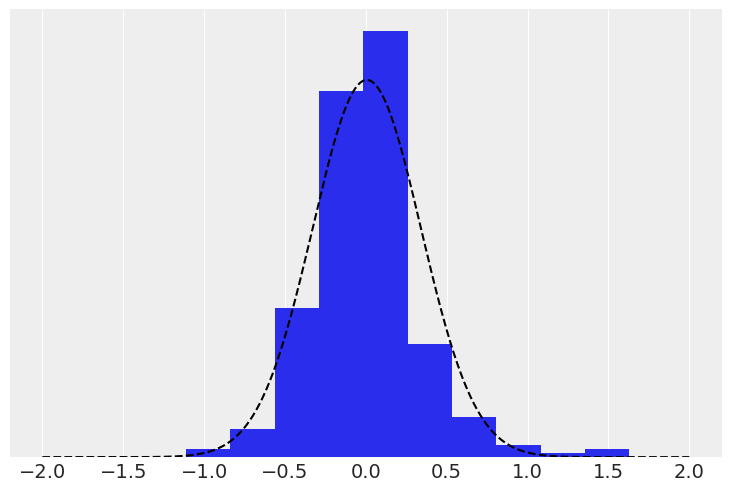

In [37]:
residuals = y_test - y_pred_xgb
res_std = residuals.std()
res_mean = residuals.mean()
print(res_mean,res_std)
x= np.linspace(-2,2,1000)
plt.hist(residuals,density=True)
plt.plot(x,norm.pdf(x,res_mean,res_std),ls='--',c='k')
plt.yticks([])
plt.tight_layout()
plt.savefig("./res_xgb.pdf")
plt.show()


In [38]:
booster = xgb_model.get_booster()
importance_dict = booster.get_score(importance_type="gain")
df_xgb_score = pd.DataFrame.from_dict(importance_dict,orient='index',columns=['weight'])
df_xgb_score = (df_xgb_score/(df_xgb_score.sum())).sort_values(by='weight',ascending=False)
# display(df_xgb_score.sort_values(by='weight',ascending=False)[:10])

In [ ]:
df_xgb_score[:10].plot(kind='bar',figsize=(12,6),legend=False)
plt.xticks(rotation=0,fontsize=12)
plt.tight_layout()
plt.xlabel("")
plt.savefig('./xgb_features.pdf')
plt.show()

### Finetuning

In [39]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# Model and tuning
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid,
                                   n_iter=30, scoring='neg_mean_squared_error',
                                   cv=5, verbose=1, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

# Evaluate
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Best Params: {random_search.best_params_}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/xgboost/data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/xgboost/data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/xgboost/data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/xgboost/data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  e

Best Params: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
MSE: 0.1014
R² Score: 0.9119


/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/xgboost/data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/xgboost/data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


In [40]:
print(f"Best Params: {random_search.best_params_}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

Best Params: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
MSE: 0.1014
R² Score: 0.9119


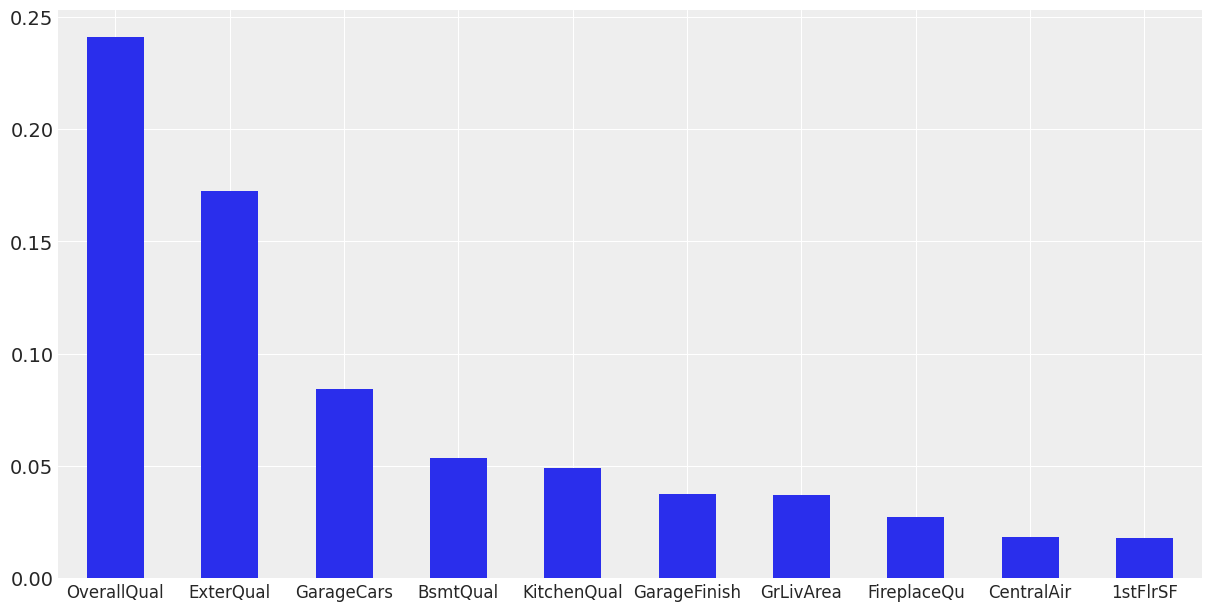

In [44]:
booster = best_model.get_booster()
importance_dict = booster.get_score(importance_type="gain")
df_xgb_ft_score = pd.DataFrame.from_dict(importance_dict,orient="index",columns=["feature"])
df_xgb_ft_score = (df_xgb_ft_score/df_xgb_ft_score.sum()).sort_values(by="feature",ascending=False)
# df_xgb_ft_score.head(5)

df_xgb_ft_score[:10].plot(kind="bar",legend=False,figsize=(12,6))
plt.xticks(rotation=0,fontsize=12)
plt.tight_layout()
plt.xlabel("")
plt.savefig('./xgb_ft_features.pdf')
plt.show()
